# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Input-preparation" data-toc-modified-id="Input-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input preparation</a></div><div class="lev1 toc-item"><a href="#Create-mosaics" data-toc-modified-id="Create-mosaics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create mosaics</a></div><div class="lev2 toc-item"><a href="#Parallel-production" data-toc-modified-id="Parallel-production-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parallel production</a></div><div class="lev1 toc-item"><a href="#xy2latlon" data-toc-modified-id="xy2latlon-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>xy2latlon</a></div><div class="lev1 toc-item"><a href="#Combining-campt-results" data-toc-modified-id="Combining-campt-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Combining campt results</a></div><div class="lev1 toc-item"><a href="#Corner-coordinates" data-toc-modified-id="Corner-coordinates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Corner coordinates</a></div>

# Input preparation

In [1]:
from hirise_tools.downloads import download_RED_product
from hirise_tools.products import RED_PRODUCT_ID

import logging
from nbtools.logging import setup_live_logging


In [2]:
from planet4 import region_data
obsids = []
for season in ['season2', 'season3']:
    for region in ['Ithaca', 'Giza', 'Manhattan2']:
        regio = getattr(region_data, region)
        season_list = getattr(regio, season)
        obsids.extend(season_list)


In [3]:
obsid = obsids[2]
obsid

'ESP_011403_0945'

In [7]:
setup_live_logging('planet4', logging.DEBUG)

# Create mosaics

In [5]:
from planet4.projection import create_RED45_mosaic
from planet4 import io

## Parallel production

In [5]:
from ipyparallel import Client
c = Client()

lbview = c.load_balanced_view()
dview = c.direct_view()

In [7]:
with c[:].sync_imports():
    from planet4.projection import create_RED45_mosaic

In [11]:
results = lbview.map_async(create_RED45_mosaic, obsids)

In [12]:
from nbtools import display_multi_progress

In [13]:
display_multi_progress(results, img_names)

In [ ]:
for res in results:
    print(res)

# xy2latlon

In [4]:
from pysis.isis import campt
from pysis.exceptions import ProcessError
import pvl
from planet4 import io

In [5]:
from pathlib import Path
edrpath = io.get_ground_projection_root()
clusterpath = io.analysis_folder() / 'p4_catalog'

In [8]:
obsid = obsids[0]
obsid

'ESP_011350_0945'

In [9]:
list(clusterpath.glob(f"{obsid}_*.csv"))

[PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches.csv'),
 PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches_base_campt_out.csv'),
 PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches_latlons.csv'),
 PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_fans.csv'),
 PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_fans_base_campt_out.csv')]

In [10]:
fpaths = [item for obsid in obsids for item in (clusterpath.glob("{}_*.csv".format(obsid)))]

In [11]:
from nbtools import execute_in_parallel

In [16]:
from ipyparallel import Client
c = Client()

lbview = c.load_balanced_view()
dview = c.direct_view()

In [17]:
with dview.sync_imports():
    from pysis.isis import campt
    from pysis.exceptions import ProcessError
    from pathlib import Path
    from ipyparallel import CompositeError

In [39]:
%%px

def do_campt(mosaicname, savepath, temppath):
    print("Calling do_campt")
    try:
        campt(from_=mosaicname, to=savepath, format='flat', append='no',
              coordlist=temppath, coordtype='image')
    except ProcessError as e:
        print(e.stderr)
        return obsid, False

def obsid_marking_from_clusterpath(inpath):
    """Find obsid and marking kind from HiRISE cluster path.
    
    For example, a cluster path like this:
    '/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches.csv'
    will return:
    ('ESP_011350_0945', 'blotches')
    """
    s = inpath.stem  # stem is 'name' (without folders) minus extension
    # s = ESP_xxxxxx_yyyy_blotches (or ..._fans)
    # obsid = s[:until last '_']
    sep = s.rfind('_')
    return s[:sep], s[sep+1:]

    
class XY2LATLON:
    blotch_coords = ['']  #, 'p1', 'p2', 'p3', 'p4']
    fan_coords = ['']   #, 'arm1', 'arm2']
    coords_switch = dict(blotches=blotch_coords, fans=fan_coords)
    
    def __init__(self, inpath):
        self.inpath = inpath
        self.edrpath = io.get_ground_projection_root()
        
    @property
    def obsid(self):
        return obsid_marking_from_clusterpath(self.inpath)[0]
    
    @property
    def marking(self):
        return obsid_marking_from_clusterpath(self.inpath)[1]
    
    @property
    def mosaicname(self):
        return f"{self.obsid}_mosaic_RED45.cub"
    
    @property
    def mosaicpath(self):
        return self.edrpath / self.obsid / self.mosaicname
    
    @property
    def df(self):
        return pd.read_csv(str(self.inpath))

    def process_inpath(self):
        df = self.df
        for coord in self.coords_switch[self.marking]:
            print("Working on coordinate:", coord)        
            if coord == '':
                name = 'base'
                tempcoords = ['x', 'y']
    #         else:
    #             name = coord
    #             tempcoords = [coord + '_x', coord + '_y']
            logger.("Tempcoords: ", tempcoords)
            temppath = inpath.with_suffix('.tocampt')
            df[tempcoords].to_csv(str(temppath), header=False, index=False)
            print("name", name)
            savename = f"{inpath.stem}_{name}_campt_out.csv"
            print("savename", savename)
            savepath = clusterpath / savename
            try:
                do_campt(mosaicpath, savepath, temppath)
            except:
                return False
        return True


def xy2latlon(inpath):
    d = dict(inpath=inpath)
    ok = process_inpath(inpath, *marking_mosaicpath_from_inpath(inpath))
    d['ok'] = ok
    return d

In [44]:
dview.push(dict(process_inpath=process_inpath,
                do_campt=do_campt,
                blotch_coords=blotch_coords,
                fan_coords=fan_coords,
                clusterpath=clusterpath,
                edrpath=edrpath))

<AsyncResult: _push>

In [48]:
results = lbview.map_async(xy2latlon, fpaths)

In [49]:
from nbtools import display_multi_progress

display_multi_progress(results, fpaths)

In [51]:
res = pd.DataFrame(results.result())

In [52]:
res.ok.value_counts()

True    113
Name: ok, dtype: int64

In [ ]:
res[res.ok==False].inpath.values

# Combining campt results

In [11]:
p = fpaths[0]
p

PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches.csv')

In [14]:
class GroundMarking(object):
    def __init__(self, resultfile):
        self.p = Path(resultfile)
        
        # this loop creates filename paths for all coords campt output files
        # and assigns them to object attributes, like
        # self.basefile, self.p1file, etc.
        self.paths = []
        self.mapped_coords = []
        for coord in self.coords:
            path = self.campt_fname(coord)
            setattr(self, coord+'file', path)
            self.paths.append(path)
            self.store_mapped_coords(coord, path)
        self.mapped_coords = pd.concat(self.mapped_coords, axis=1)
        newpath = self.p.with_name(self.p.stem+'_latlons.csv')
        self.mapped_coords.to_csv(str(newpath), index=False)
        self.coordspath = newpath

    def campt_fname(self, coordname):
        return self.p.with_name(self.p.stem + '_{}_campt_out.csv'.format(coordname))
    
    def store_mapped_coords(self, coord, path):
        df = pd.read_csv(path)
        subdf = df[['PlanetographicLatitude',
                    'PositiveEast360Longitude']]
        subdf.columns = [coord+'_lat', coord+'_lon']
        self.mapped_coords.append(subdf)

class GroundBlotch(GroundMarking):
    coords = ['base']  #, 'p1', 'p2', 'p3', 'p4']
    kind = 'blotch'


class GroundFan(GroundMarking):
    coords = ['base', 'arm1', 'arm2']
    kind = 'fan'

    
def get_ground_marking(fname):
    tokens = Path(fname).stem.split('_')
    if tokens[-1] == 'blotches':
        return GroundBlotch(fname)
    else:
        return GroundFan(fname)

In [16]:
p

PosixPath('/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches.csv')

In [15]:
for path in fpaths:
    print(path.stem)
    get_ground_marking(path)

ESP_011350_0945_blotches


ESP_011350_0945_blotches_base_campt_out


FileNotFoundError: File b'/Users/klay6683/Dropbox/data/planet4/p4_analysis/p4_catalog/ESP_011350_0945_blotches_base_campt_out_base_campt_out.csv' does not exist

# Corner coordinates

In [6]:
from planet4.projection import CornerCalculator

In [7]:
edrpath

PosixPath('/Volumes/Data/planet4/p4_ground_projection')

In [8]:
cubepaths = !ls {edrpath}/**/*RED45.cub

In [9]:
cubepaths[:5]

['/Volumes/Data/planet4/p4_ground_projection/ESP_011350_0945/ESP_011350_0945_mosaic_RED45.cub',
 '/Volumes/Data/planet4/p4_ground_projection/ESP_011351_0945/ESP_011351_0945_mosaic_RED45.cub',
 '/Volumes/Data/planet4/p4_ground_projection/ESP_011394_0935/ESP_011394_0935_mosaic_RED45.cub',
 '/Volumes/Data/planet4/p4_ground_projection/ESP_011403_0945/ESP_011403_0945_mosaic_RED45.cub',
 '/Volumes/Data/planet4/p4_ground_projection/ESP_011404_0945/ESP_011404_0945_mosaic_RED45.cub']

In [10]:
cubepaths[3]

'/Volumes/Data/planet4/p4_ground_projection/ESP_011403_0945/ESP_011403_0945_mosaic_RED45.cub'

In [11]:
cornercalc = CornerCalculator(cubepaths[3])

In [16]:
cornercalc.calc_tile_coords()

TypeError: cannot concatenate a non-NDFrame object

In [12]:
cornercalc.get_lats_lon(1, 1)

{'lat_centric': Units(value=-85.42451437128, units='DEGREE'),
 'lat_graphic': Units(value=-85.477994488214, units='DEGREE'),
 'lon': Units(value=178.14760933895, units='DEGREE')}

In [13]:
from planet4 import projection

In [15]:
group = projection.get_campt_label(cornercalc.cubepath, 1,1)

In [17]:
val = group['PlanetocentricLatitude']

In [18]:
type(val)

pvl._collections.Units

In [19]:
val.value

-85.42451437128

In [36]:
db = io.DBManager()
data = db.get_image_name_markings(cornercalc.img_name)

In [40]:
data.y_tile.max()

82

In [43]:
data.image_x.max()

1603.5

In [44]:
data.image_y.max()

44992.0

In [46]:
cornercalc.img_x_size = 740

In [53]:
cornercalc.LL

(1, 45036)

In [52]:
cornercalc.img_y_size = 648

In [56]:
data.query('x_tile==2 and y_tile==82').image_id.unique()

array(['APF0000awd'], dtype=object)

In [57]:
from planet4 import markings

In [58]:
p4id = markings.ImageID('awd')

In [59]:
%matplotlib inline

In [63]:
def transform(x, y, xtile, ytile):
    x_offset = 740
    y_offset = 548
    x_HiRISE = x + ((x_offset)*(xtile-1))  # **formula
    y_HiRISE = y + ((y_offset)*(ytile-1))  # **formula

    return x_HiRISE, y_HiRISE


In [73]:
transform(0,548, 2, 82)

(740, 44936)

In [70]:
p4id.data.x.max()

837.0

In [ ]:
data.y

planet4.io - Found image in cache.


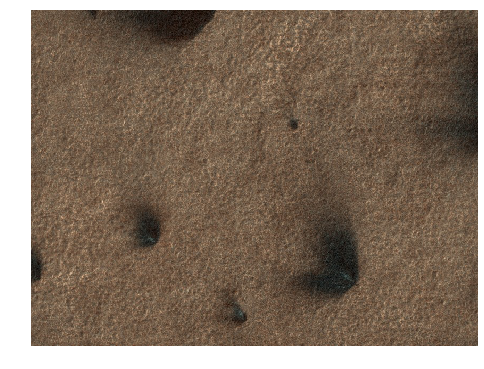

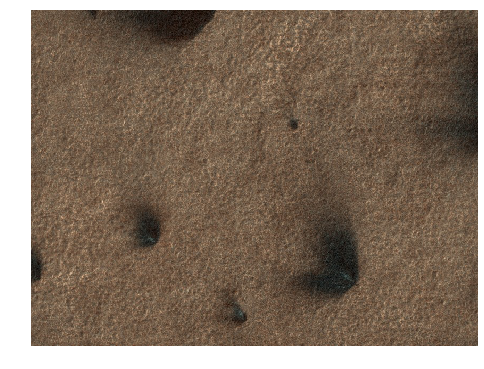

In [72]:
p4id.show_subframe()

In [62]:
p4id.data.image_y.max()

44992.0

In [41]:
cornercalc.calc_corners()

b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011403_0945
Corner: LL
Pixels: (1, 45036)
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011403_0945
Corner: LR
Pixels: (1580, 45036)
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'


,UL_lat_centric,UL_lat_graphic,UL_lon,UR_lat_centric,UR_lat_graphic,UR_lon
ESP_011403_0945,-85.424514,-85.477994,178.147609,-85.42901,-85.482438,178.322985


In [87]:
bucket = []
for cube in cubepaths:
    print(Path(cube).stem)
    cc = CornerCalculator(cube)
    bucket.append(cc.calc_corners())

ESP_011350_0945_mosaic_RED45
ESP_011351_0945_mosaic_RED45
ESP_011394_0935_mosaic_RED45
ESP_011403_0945_mosaic_RED45
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011403_0945
Corner: LL
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011403_0945
Corner: LR
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011404_0945_mosaic_RED45
ESP_011447_0950_mosaic_RED45
ESP_011448_0950_mosaic_RED45
ESP_011671_0935_mosaic_RED45
ESP_011777_0950_mosaic_RED45
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011777_0950
Corner: LL
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
b''
b'**ERROR** Requested position does not project in camera model; not inside cube.\n'
ESP_011777_0950
Corner: LR
b''
b'**

In [242]:
p = '/Volumes/Data/planet4/season2_3_EDRs/redMosaicESP_011729_0985.cub'

In [214]:
meta = pd.read_hdf('/Users/klay6683/Dropbox/SternchenAndMe/python_stuff/hirise_rdr_index.hdf')

In [260]:
results = pd.concat(bucket)

In [263]:
results.index.name = 'img_name'

In [264]:
results.to_csv('inca_city_corners.csv')

In [267]:
pd.read_csv('inca_city_corners.csv', index_col=0)

,LL_lat_centric,LL_lat_graphic,LL_lon,LR_lat_centric,LR_lat_graphic,LR_lon,UL_lat_centric,UL_lat_graphic,UL_lon,UR_lat_centric,UR_lat_graphic,UR_lon
img_name,,,,,,,,,,,,
ESP_011491_0985,-81.043308,-81.146761,64.408759,-81.046746,-81.150160,64.492252,-81.608252,-81.705371,63.379774,-81.611903,-81.708981,63.468602
ESP_011544_0985,-81.237932,-81.339207,64.432719,-81.242740,-81.343961,64.512531,-81.506814,-81.605073,63.712657,-81.511836,-81.610039,63.795767
ESP_011557_0985,-81.340158,-81.440288,63.906422,-81.344076,-81.444162,63.991104,-81.598576,-81.695804,63.362293,-81.602592,-81.699774,63.449039
ESP_011623_0985,-81.348902,-81.448933,63.907439,-81.353185,-81.453168,63.990631,-81.582773,-81.680178,63.359635,-81.587167,-81.684523,63.444878
ESP_011702_0985,-81.306263,-81.406773,63.945430,-81.309857,-81.410326,64.030174,-81.626161,-81.723078,63.330430,-81.629923,-81.726798,63.419220
ESP_011729_0985,NaN,NaN,NaN,NaN,NaN,NaN,-81.548335,-81.646127,63.296442,-81.557279,-81.654971,63.389975
ESP_011900_0985,-81.321088,-81.421431,64.220755,-81.325864,-81.426154,64.303953,-81.632317,-81.729165,63.401962,-81.637257,-81.734049,63.487733
ESP_012256_0985,-81.280180,-81.380982,64.303609,-81.285609,-81.386350,64.402340,-81.475910,-81.574516,63.822367,-81.481468,-81.580011,63.923293
ESP_012322_0985,-81.391051,-81.490610,63.835602,-81.397132,-81.496622,63.935373,-81.544341,-81.642178,63.408896,-81.550468,-81.648236,63.509241
